### Forecasting in Aquaponics

Libraries and setup

In [95]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import sys

os.environ['KMP_DUPLICATE_LIB_OK']='True'

#np.set_printoptions(threshold=sys.maxsize)

#mpl.rcParams['figure.figsize'] = (14, 8)
mpl.rcParams['axes.grid'] = True

np.random.seed(10)

## Data adquisition

### Syntetic signal generation

In [96]:
def get_signal():
    
    n_input = 30
    n_samples = int(1e4)

    frec_min = 0
    frec_max = int(1e3)

    phase_min = 0
    phase_max = int(1e3)

    frec_input = np.random.randint(frec_min, frec_max, size= (n_input))
    frec_input = frec_input.reshape(n_input, 1)
    
    phase_input = np.random.randint(phase_min, phase_max, size= (n_input))

    t = np.arange(n_samples)
    t = t.reshape(n_samples, 1)
    
    signal_input = np.sin(t * frec_input.T  + phase_input)
    signal_nl = np.sqrt(np.abs(signal_input))
    signal_output = signal_nl.sum(axis = 1).reshape(n_samples, 1)
    
    signal = np.concatenate((signal_output, signal_input), axis = 1)
    
    df = pd.DataFrame(signal)
    
    return df

df_grouped = get_signal()
print(df_grouped.head())

          0         1         2         3         4         5         6   \
0  23.456862 -0.997801 -0.873297  0.795861  0.106077 -0.836689 -0.149818   
1  20.014177 -0.506314 -0.988036 -0.860146 -0.629794 -0.521628 -0.958950   
2  20.921335  0.544097 -0.683284  0.913044 -0.994808 -0.106107  0.412009   
3  23.876664  0.993875 -0.088429 -0.953852 -0.774024  0.329849  0.846301   
4  22.883556  0.346508  0.543971  0.982032 -0.097452  0.702279 -0.643400   

         7         8         9   ...        21        22        23        24  \
0 -0.558789  0.999520  0.573407  ...  0.529108  0.475497  0.945416 -0.245194   
1  0.877590  0.498739 -0.750908  ...  0.751027  0.279329 -0.236574 -0.008761   
2 -0.999756 -0.529057 -0.739323  ...  0.909335  0.070602 -0.689785  0.228170   
3  0.897914 -0.997801  0.587551  ...  0.990624 -0.141299  0.981924  0.452133   
4 -0.594884 -0.412173  0.869145  ...  0.988008 -0.346847 -0.371236  0.650402   

         25        26        27        28        29        30 

Organize data in columns

Data visualization

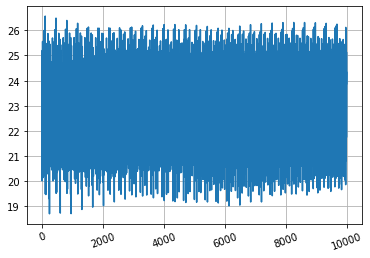

In [97]:
sample_sensor = 0

df_grouped[sample_sensor].plot()
plt.xticks(rotation=20)
plt.show()

## Data Pre-processing

### Selecting target 

In [98]:
label_target = {
0: 'Results'}

### Denoising dataframe - FFT filter

Check sampling frecuency

In [99]:
sampling_time = df_grouped.index.to_series().diff().median()
print(sampling_time)

1.0


Design sample filter

In [100]:
df_clean = df_grouped.copy()

### Feature selection via correlation analysis

In [101]:
# corr_mat = np.abs(df_clean.corr(method='pearson'))
# sns.heatmap(corr_mat)
# plt.show()

# corr_thl = 0.10
# corr_label = np.zeros(df_grouped.shape[1])

# for i in label_target:
#     corr_label = corr_label | (corr_mat[i] > corr_thl)

# df_clean = df_clean.loc[:, corr_label]

Describe  dataset

In [102]:
# print(df_clean.describe().transpose())

## Split dataset: train, validation and test

In [103]:
total_data = len(df_clean)

train_perc, val_perc, test_perc = 0.7, 0.2, 0.1

train_df    = df_clean[0:int(total_data*train_perc)]
val_df      = df_clean[int(total_data*train_perc):int(total_data*(train_perc + val_perc))]
test_df     = df_clean[int(total_data*(train_perc + val_perc)):total_data]

## Data normalization

Min-max normalization

In [104]:
def f_normalize_minmax(df, full_df):
    norm_df = (df - full_df.min()) / (full_df.max() - full_df.min())
    return norm_df

def f_inv_normalize_minmax(norm_df, full_df):
    df = norm_df * (full_df.max() - full_df.min()) + full_df.min()
    return df

norm_train_df   = f_normalize_minmax(train_df, df_clean)
norm_val_df     = f_normalize_minmax(val_df, df_clean)
norm_test_df    = f_normalize_minmax(test_df, df_clean)

Show tails with box plot

In [105]:
# melt_train_df = norm_train_df.melt(var_name = 'Label', value_name = 'Normalized value')
# plt.figure()
# ax = sns.violinplot(x = 'Label', y = 'Normalized value', data = melt_train_df)
# plt.show()

Plot normalized data

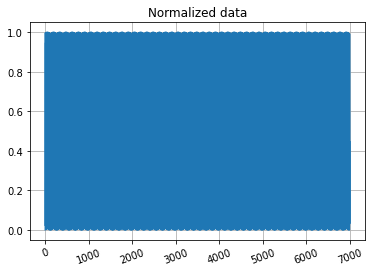

In [106]:
norm_train_df[1].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.title('Normalized data')
plt.show()

## Create input and target dataframe - Window generation

In [107]:
n_hour_data = 65 # 65 entries ~ 1 hour - There is a variable sampling frecuency
n_hours_in  = 1
n_hours_out = 1

input_width     = n_hour_data * n_hours_in 
label_width     = n_hour_data * n_hours_out 
offset_width    = 1 # 1 as default

def f_window_gen(df, label_target, input_width, label_width, offset_width):

    time_range = df.index
    data = []
    target = []

    data_time = []
    target_time = []

    for i in range(len(time_range) - (input_width + offset_width + label_width)):
        range_data = df.loc[time_range[i]:time_range[input_width + i]].values
        data.append(range_data)
        data_time.append(time_range[i:input_width + i])

        range_target = df[label_target].loc[time_range[input_width + offset_width + i: input_width + offset_width + label_width + i]].values
        target.append(range_target.flatten('F'))
        target_time.append(time_range[input_width + offset_width + i: input_width + offset_width + label_width + i])

    data = np.array(data)
    target = np.array(target)

    return data, target, data_time, target_time

train_data, train_target, train_data_time, train_target_time = f_window_gen(norm_train_df, label_target, input_width, label_width, offset_width)
val_data, val_target, val_data_time, val_target_time = f_window_gen(norm_val_df, label_target, input_width, label_width, offset_width)
test_data, test_target, test_data_time, test_target_time = f_window_gen(norm_test_df, label_target, input_width, label_width, offset_width)

Plotting - Normalized values

In [108]:
def plot_results(label_target, label_time, label, results, label_width):
    n_label = np.int(len(label_target))

    sensor_tag = list(label_target.values())

    print(label_time.shape)
    
    fig, ax = plt.subplots(n_label, sharex = 'all')
    
    for i in range(n_label):
        label_plot = label[((i) * label_width): ((i + 1)* label_width)]
        ax.plot(label_time, label_plot, color = 'blue', label = 'Real')
        
        results_plot = results[((i) * label_width): ((i + 1)* label_width)]
        ax.plot(label_time, results_plot, color = 'orange', label = 'Prediction')

        ax.set_ylabel(sensor_tag[i])

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('Day - Time')
    plt.show()

    pass

### Plotting - History

In [109]:
def plot_history(history):

    acc = history.history['mean_absolute_error']
    val_acc = history.history['val_mean_absolute_error']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    fig, ax = plt.subplots(2, sharex = 'all')

    # Plot training and validation accuracy per epoch
    ax[0].plot(epochs, acc, label = 'Training')
    ax[0].plot(epochs, val_acc, label = 'Validation')
    ax[0].title.set_text('Training and validation MAE')

    # Plot training and validation loss per epoch
    ax[1].plot(epochs, loss, label = 'Training')
    ax[1].plot(epochs, val_loss, label = 'Validation')
    ax[1].title.set_text('Training and validation loss')

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('epochs')
    plt.show()

## Architecture and Deployment

Callbacks

In [110]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.9

Training method

In [129]:
def compile_and_fit(model, train_data, train_target, val_data, val_target, 
                    test_data, test_target, max_epochs, batch_size, test_entry, label_width):

    # Add callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                  patience = 5)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 0)
    callbacks = [early_stop, lr_scheduler]

    # Model compile
    model.compile(loss      = tf.losses.MeanSquaredError(),
                  optimizer = tf.optimizers.Adam(),
                  metrics   = [tf.metrics.MeanAbsoluteError()])

    # Model fit
    history = model.fit(train_data,
                        train_target,
                        batch_size = batch_size,
                        epochs  = max_epochs,
                        verbose = 1,
                        shuffle = False, 
                        validation_data = (val_data, val_target),
                        callbacks = callbacks)

    model.summary()
    
    # Model evaluate
    model.evaluate(test_data, test_target)

    # Test model
    test_data = np.reshape(test_data[test_entry], (1, test_data[0].shape[0], test_data[0].shape[1]))
    test_prediction = model.predict(test_data)
    
    test_prediction = np.squeeze(test_prediction)
    print(test_prediction.shape)
    
    # Plot results
    plot_results(label_target, test_target_time[test_entry], test_target[test_entry], test_prediction, label_width)

    plot_history(history)

    return history, test_prediction

test_entry = np.random.randint(0, 100)

# Models

## Linear model

In [124]:
def f_linear_model(label_target, label_width):
    model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            
            tf.keras.layers.Dense(units = 1000, kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
        
            tf.keras.layers.Dense(units = 500, kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
            
            tf.keras.layers.Dense(units = 300, kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
        
        
            tf.keras.layers.Dense(units = len(label_target) * label_width, kernel_initializer='random_normal', bias_initializer='zeros')])
    return model

linear_model = f_linear_model(label_target, label_width)

Train on 6869 samples, validate on 1869 samples
Epoch 1/30
6869/6869 [==============================] - 1s 128us/sample - loss: 0.5549 - mean_absolute_error: 0.4490 - val_loss: 0.0163 - val_mean_absolute_error: 0.1026
Epoch 2/30
6869/6869 [==============================] - 0s 43us/sample - loss: 0.0291 - mean_absolute_error: 0.1357 - val_loss: 0.0148 - val_mean_absolute_error: 0.0973
Epoch 3/30
6869/6869 [==============================] - 0s 42us/sample - loss: 0.0219 - mean_absolute_error: 0.1180 - val_loss: 0.0139 - val_mean_absolute_error: 0.0939
Epoch 4/30
6869/6869 [==============================] - 0s 44us/sample - loss: 0.0204 - mean_absolute_error: 0.1140 - val_loss: 0.0146 - val_mean_absolute_error: 0.0966
Epoch 5/30
6869/6869 [==============================] - 0s 44us/sample - loss: 0.0199 - mean_absolute_error: 0.1124 - val_loss: 0.0148 - val_mean_absolute_error: 0.0977
Epoch 6/30
6869/6869 [==============================] - 0s 45us/sample - loss: 0.0195 - mean_absolute_erro

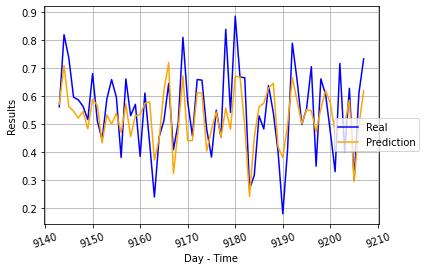

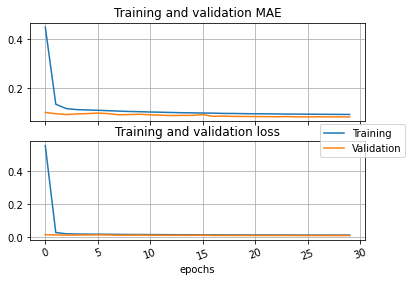

In [130]:
max_epochs = 30
batch_size = 100

linear_history, linear_prediction = compile_and_fit(linear_model, train_data, train_target, val_data, val_target, 
                                                    test_data, test_target, max_epochs, batch_size, test_entry, label_width)

## MLP model

In [131]:
def f_mlp_model(label_target, label_width):
    model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
        
            tf.keras.layers.Dense(units = 1000, activation = 'tanh', kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
            
            tf.keras.layers.Dense(units = 700, activation = 'tanh', kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
        
            tf.keras.layers.Dense(units = 500, activation = 'tanh', kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
            
            tf.keras.layers.Dense(units = len(label_target) * label_width)])
    return model
    
mlp_model = f_mlp_model(label_target, label_width)

Train on 6869 samples, validate on 1869 samples
Epoch 1/30
6869/6869 [==============================] - 3s 413us/sample - loss: 0.0171 - mean_absolute_error: 0.1040 - val_loss: 0.0105 - val_mean_absolute_error: 0.0820
Epoch 2/30
6869/6869 [==============================] - 1s 82us/sample - loss: 0.0151 - mean_absolute_error: 0.0978 - val_loss: 0.0098 - val_mean_absolute_error: 0.0796
Epoch 3/30
6869/6869 [==============================] - 1s 81us/sample - loss: 0.0142 - mean_absolute_error: 0.0948 - val_loss: 0.0085 - val_mean_absolute_error: 0.0738
Epoch 4/30
6869/6869 [==============================] - 1s 81us/sample - loss: 0.0130 - mean_absolute_error: 0.0907 - val_loss: 0.0084 - val_mean_absolute_error: 0.0735
Epoch 5/30
6869/6869 [==============================] - 1s 83us/sample - loss: 0.0121 - mean_absolute_error: 0.0874 - val_loss: 0.0074 - val_mean_absolute_error: 0.0690
Epoch 6/30
6869/6869 [==============================] - 1s 82us/sample - loss: 0.0108 - mean_absolute_erro

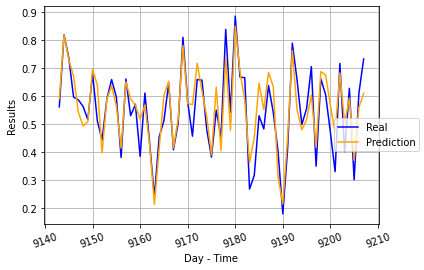

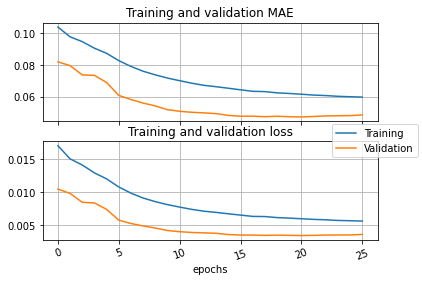

In [133]:
max_epochs = 30
batch_size = 50
mlp_history, mlp_prediction = compile_and_fit(mlp_model, train_data, train_target, val_data, val_target, 
                                              test_data, test_target, max_epochs, batch_size, test_entry, label_width)

## LSTM RNN model

In [134]:
def f_lstm_model(input_shape, output_shape):
    model = tf.keras.Sequential([
        
            tf.keras.layers.LSTM(units = 1000, input_shape = input_shape, kernel_initializer='random_normal', bias_initializer='zeros', dropout=0.2, return_sequences=True),
        
            tf.keras.layers.LSTM(units = 700, input_shape = input_shape, kernel_initializer='random_normal', bias_initializer='zeros', dropout=0.2, return_sequences=False),

            tf.keras.layers.Dense(output_shape)])
    return model

input_shape = train_data[0].shape
output_shape = train_target.shape[1]
lstm_model = f_lstm_model(input_shape, output_shape)

Train on 6869 samples, validate on 1869 samples
Epoch 1/30
6869/6869 [==============================] - 11s 2ms/sample - loss: 0.0336 - mean_absolute_error: 0.1391 - val_loss: 0.0277 - val_mean_absolute_error: 0.1336
Epoch 2/30
6869/6869 [==============================] - 7s 1ms/sample - loss: 0.0258 - mean_absolute_error: 0.1280 - val_loss: 0.0276 - val_mean_absolute_error: 0.1335
Epoch 3/30
6869/6869 [==============================] - 7s 1ms/sample - loss: 0.0257 - mean_absolute_error: 0.1276 - val_loss: 0.0275 - val_mean_absolute_error: 0.1333
Epoch 4/30
6869/6869 [==============================] - 7s 1ms/sample - loss: 0.0256 - mean_absolute_error: 0.1272 - val_loss: 0.0274 - val_mean_absolute_error: 0.1329
Epoch 5/30
6869/6869 [==============================] - 7s 1ms/sample - loss: 0.0254 - mean_absolute_error: 0.1267 - val_loss: 0.0271 - val_mean_absolute_error: 0.1321
Epoch 6/30
6869/6869 [==============================] - 7s 1ms/sample - loss: 0.0246 - mean_absolute_error: 0.1

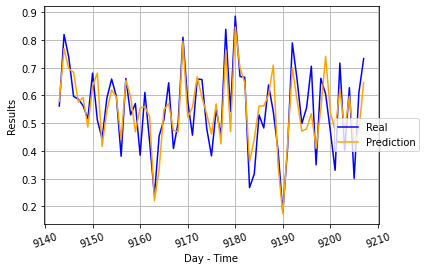

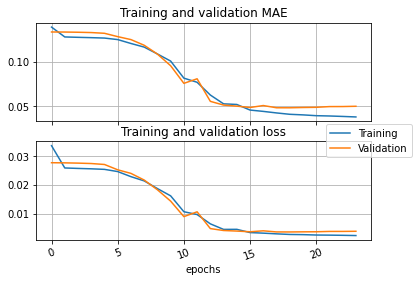

In [135]:
max_epochs = 30
batch_size = 50
lstm_history, lstm_prediction = compile_and_fit(lstm_model, train_data, train_target, val_data, val_target, 
                                                test_data, test_target, max_epochs, batch_size, test_entry, label_width)

## GRU RNN model 

In [118]:
def f_gru_model(input_shape, output_shape):
    model = tf.keras.Sequential([
            tf.keras.layers.GRU(units = 1000, input_shape = input_shape, kernel_initializer='random_normal', bias_initializer='zeros', dropout=0.2, return_sequences=False),

            tf.keras.layers.Dense(output_shape)])
    return model

input_shape = train_data[0].shape
output_shape = train_target.shape[1]
gru_model = f_gru_model(input_shape, output_shape)

Train on 6869 samples, validate on 1869 samples
Epoch 1/30
6869/6869 [==============================] - 5s 798us/sample - loss: 0.0315 - mean_absolute_error: 0.1386 - val_loss: 0.0272 - val_mean_absolute_error: 0.1325
Epoch 2/30
6869/6869 [==============================] - 3s 501us/sample - loss: 0.0253 - mean_absolute_error: 0.1266 - val_loss: 0.0265 - val_mean_absolute_error: 0.1306
Epoch 3/30
6869/6869 [==============================] - 3s 498us/sample - loss: 0.0242 - mean_absolute_error: 0.1239 - val_loss: 0.0247 - val_mean_absolute_error: 0.1264
Epoch 4/30
6869/6869 [==============================] - 3s 491us/sample - loss: 0.0220 - mean_absolute_error: 0.1183 - val_loss: 0.0214 - val_mean_absolute_error: 0.1183
Epoch 5/30
6869/6869 [==============================] - 3s 497us/sample - loss: 0.0185 - mean_absolute_error: 0.1082 - val_loss: 0.0162 - val_mean_absolute_error: 0.1026
Epoch 6/30
6869/6869 [==============================] - 3s 496us/sample - loss: 0.0136 - mean_absolute

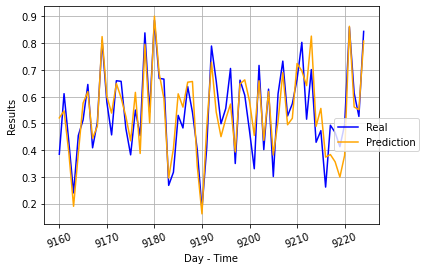

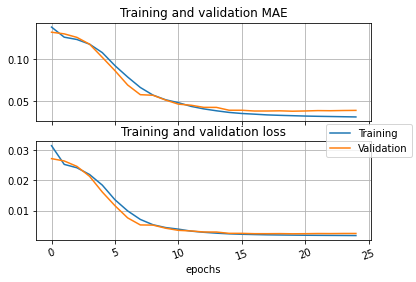

In [119]:
max_epochs = 30
batch_size = 50
gru_history, gru_prediction = compile_and_fit(gru_model, train_data, train_target, val_data, val_target, 
                                              test_data, test_target, max_epochs, batch_size, test_entry, label_width)